## Модельные данные

In [1]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Зададим размер выборок $n_1=700$, $n_2=1000$, векторы средних $mu_1$ и $mu_2$

In [260]:
def generate_cov_matrix(n_features: int, corr_level: float) -> np.ndarray:
    # Создаем квадратную матрицу из нулей
    cov = np.zeros((n_features, n_features))
    # Заполняем диагональные элементы единицами
    np.fill_diagonal(cov, 1)
    # Заполняем элементы выше диагонали и ниже диагонали
    for i in range(n_features):
        for j in range(i + 1, n_features):
            cov[i][j] = cov[j][i] = corr_level
    return cov

In [128]:
n_1 = 700
n_2 = 1000

mu_1 = [0.63, 0.42, 0.34]
mu_2 = [1.3, 2, 0.25]

s_cov = np.array([[1. , 0.9, 0.8],
                  [0.9, 1. , 0.9],
                  [0.8, 0.9, 1. ]])

# s_cov = np.array([[5. , 0.7, 0.7],
#                   [0.7, 3. , 0.7],
#                   [0.7, 0.7, 7. ]])

Создаем 0.6 первой выборки + 0.4 второй

In [115]:
sample_1 = multivariate_normal(mean=mu_1, cov=s_cov).rvs(n_1, random_state=123)
sample_2 = multivariate_normal(mean=mu_2, cov=s_cov).rvs(n_2, random_state=123)
n_sample_1 = int(0.4 * n_1)
n_sample_2 = int(0.6 * n_2)


# indices_1 = np.random.choice(n_1, n_sample_1, replace=False)
indices_1 = range(n_sample_1)
modified_sample_1 = sample_1[indices_1]

# indices_2 = np.random.choice(n_2, n_sample_2, replace=False)
indices_2 = range(n_sample_2)
modified_sample_2 = sample_2[indices_2]
# Объединяем выборки
modified_sample = np.vstack((modified_sample_1, modified_sample_2))

sample_1 = np.delete(sample_1, indices_1, axis=0)
sample_2 = np.delete(sample_2, indices_2, axis=0)
samples = np.vstack((sample_1, sample_2))

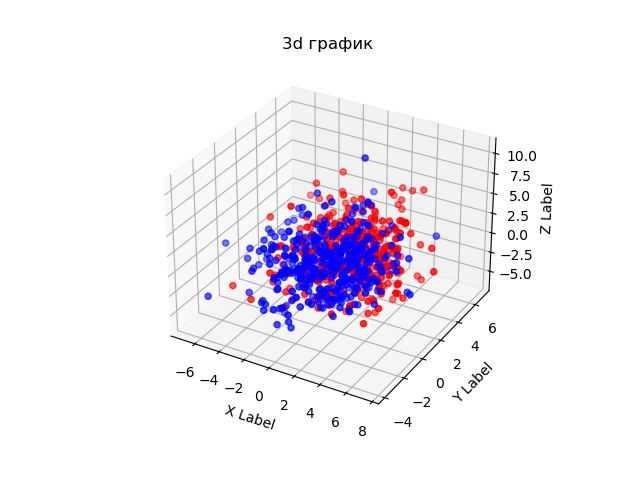

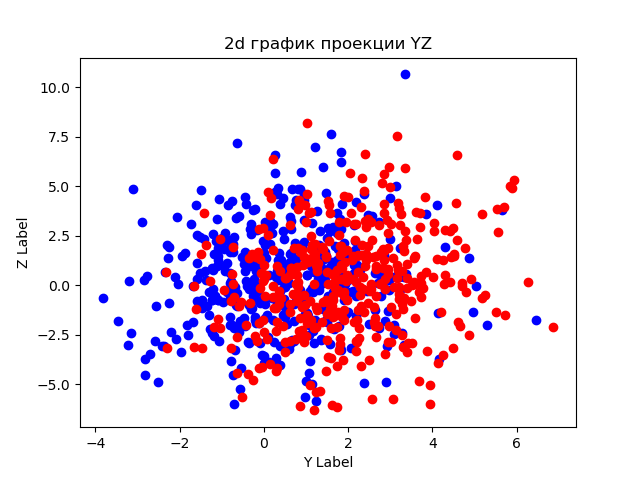

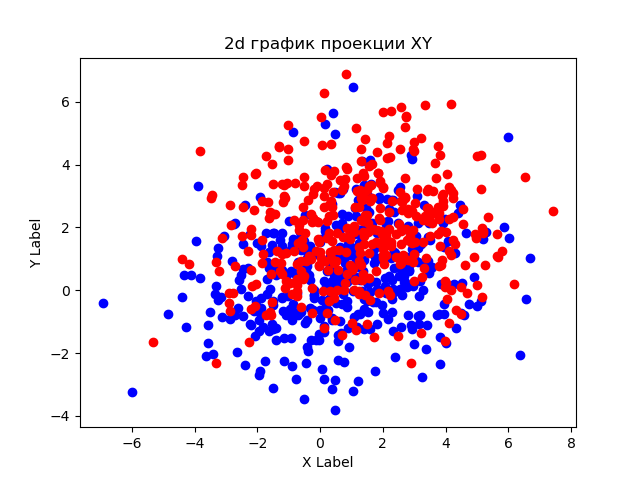

In [116]:
import matplotlib
matplotlib.use('module://ipympl.backend_nbagg')
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(sample_1[:, 0],sample_1[:, 1],sample_1[:, 2], color='b')
ax.scatter(sample_2[:, 0],sample_2[:, 1],sample_2[:, 2], color='r')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title("3d график")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(sample_1[:, 1],sample_1[:, 2], color='b')
ax.scatter(sample_2[:, 1],sample_2[:, 2], color='r')
ax.set_xlabel('Y Label')
ax.set_ylabel('Z Label')
plt.title("2d график проекции YZ")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(sample_1[:, 0],sample_1[:, 1], color='b')
ax.scatter(sample_2[:, 0],sample_2[:, 1], color='r')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
plt.title("2d график проекции XY")
plt.show()

Выборочные оценки выборок

In [117]:
# оценка среднего
mu_1_est = np.mean(sample_1, axis=0)
mu_2_est = np.mean(sample_2, axis=0)

# оценка матрицы ковариаций
s1 = np.cov(sample_1, rowvar=False, ddof=1)
s2 = np.cov(sample_2, rowvar=False, ddof=1)
s_est = 1/(sample_1.shape[0]+sample_2.shape[0]-2)*((sample_1.shape[0]-1)*s1 + (sample_2.shape[0]-1)*s2)

# оценка альфа
alfa_est = np.dot(np.linalg.inv(s_est),(mu_1_est - mu_2_est))

# z_j, j = 1,2
z_1 = np.dot(sample_1, alfa_est)
z_1_mean = np.mean(z_1, axis=0)

z_2 = np.dot(sample_2, alfa_est)
z_2_mean = np.mean(z_2, axis=0)


# оценка дисперсии
sigma = np.dot(alfa_est, s_est).dot(alfa_est.T)

Вычисление на тестовых данных принадлежности к классу

In [111]:
from scipy import integrate
from scipy.stats import norm
import math
from scipy.integrate import quad
# Функция Ф
def calculate_function(y):
    def f(t):
        return math.exp(-t ** 2 / 2)

    integral, _ = quad(f, -np.inf, y)
    normal = norm.pdf(y)
    result = (1 / math.sqrt(2 * math.pi)) * integral / normal
    return result

Смещенное расстояние Махаланобиса = 0.881191812529616, 
Несмещенное расстояние Махаланобиса = 0.8622399489685211

Оценка вероятностей ошибок классификации с использованием несмещенного расстояния Махаланобиса:
P_21 = 0.30263819067267683, P_12 = 0.3402646433750389
Вероятность ошибочной классификации = 0.32099255784456077

Оценка вероятностей ошибок классификации по обучающей выборке 
P_21 = 0.31865284974093266,P_12 = 0.315668202764977
Вероятность ошибочной классификации = 0.3171969243868079

Вероятности ошибок классификации на тестовой выборке
P_21 = 0.18,P_12 = 0.5
Вероятность ошибочной классификации = 0.3360975609756097


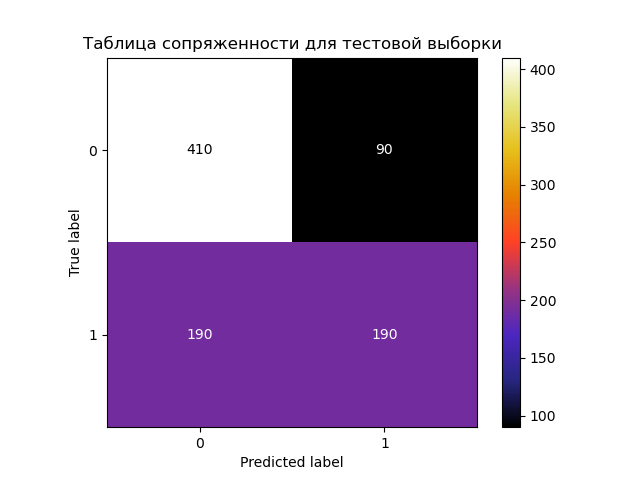

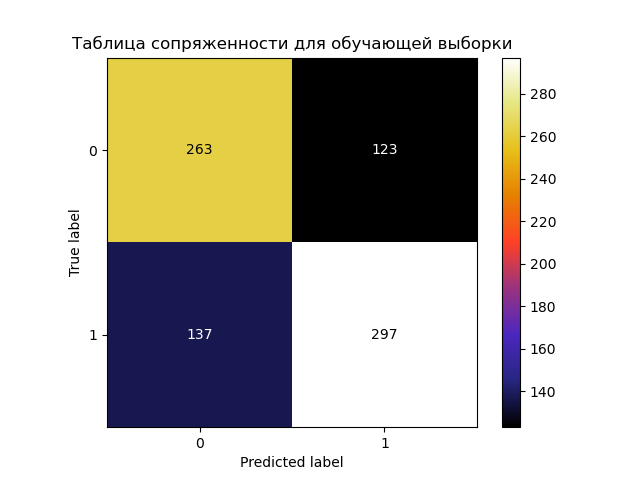

In [118]:
q_1 = sample_1.shape[0]/(samples.shape[0])
q_2 = sample_2.shape[0]/(samples.shape[0])
n1 = sample_1.shape[0]
n2 = sample_2.shape[0]
p = 3


def define_class(sample):
    limit = (z_1_mean + z_2_mean) / 2 + np.log(q_2/q_1)
    res = []
    for x in sample:
        res.append(1 if np.dot(alfa_est, x) >= limit else 0)
    return res

mah = ((z_1_mean - z_2_mean)**2) / sigma
mah_unbiased = (n1 + n2 - p - 3) * mah / (n1 + n2 - 2) - p * (1/n1 + 1/n2)
print(f'Смещенное расстояние Махаланобиса = {mah}, \nНесмещенное расстояние Махаланобиса = {mah_unbiased}')
check = define_class(modified_sample)
F = lambda x: norm.cdf(x)

P_21_est = F((np.log(q_2/q_1) - 0.5*mah_unbiased)/np.sqrt(mah_unbiased))
P_12_est = F((-np.log(q_2/q_1) - 0.5*mah_unbiased)/np.sqrt(mah_unbiased))

print(f'\nОценка вероятностей ошибок классификации с использованием несмещенного расстояния Махаланобиса:\nP_21 = {P_21_est}, P_12 = {P_12_est}\nВероятность ошибочной классификации = {P_21_est*q_1 + P_12_est*q_2}')
n_samples = define_class(samples)
matrix_2 = confusion_matrix(n_samples, np.hstack([np.ones(n1), np.zeros(n2)]))
matrix_2 = np.array(matrix_2)

P_21_emp = matrix_2[0][1]/(matrix_2[0][1]+matrix_2[0][0])
P_12_emp = matrix_2[1][0]/(matrix_2[1][0]+matrix_2[1][1])

print(f'\nОценка вероятностей ошибок классификации по обучающей выборке \nP_21 = {P_21_emp},P_12 = {P_12_emp}\nВероятность ошибочной классификации = {P_21_emp*q_1 + P_12_emp*q_2}')

matrix_1 = confusion_matrix(check, np.hstack([np.ones(n_1 - n1), np.zeros(n_2 - n2)]))
matrix_1 = np.array(matrix_1)

P_21_emp = matrix_1[0][1]/(matrix_1[0][1]+matrix_1[0][0])
P_12_emp = matrix_1[1][0]/(matrix_1[1][0]+matrix_1[1][1])

print(f'\nВероятности ошибок классификации на тестовой выборке\nP_21 = {P_21_emp},P_12 = {P_12_emp}\nВероятность ошибочной классификации = {P_21_emp*q_1 + P_12_emp*q_2}')
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_1)
disp.plot(cmap='CMRmap')
plt.title("Таблица сопряженности для тестовой выборки")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=matrix_2)
disp.plot(cmap='CMRmap')
plt.title("Таблица сопряженности для обучающей выборки")
plt.show()

# Реальные данные

In [40]:
from scipy import integrate
from scipy.stats import norm
from scipy.stats import gaussian_kde
import math
def kde_value(y, data):
    kde = gaussian_kde(data, bw_method='isj')
    return kde.evaluate(y)

def calculate_function_realdata(y, data):
    # Определение функции, которую нужно проинтегрировать
    def f(t):
        return math.exp(-t ** 2 / 2)

    # Вычисление интеграла с помощью функции quad из модуля scipy.integrate
    integral, _ = integrate.quad(f, -math.inf, y)

    # Вычисление значения плотности распределения с помощью KDE в точке y
    dist = kde_value(y, data)

    # Вычисление значения искомой функции
    result = (1 / math.sqrt(2 * math.pi)) * integral / dist

    return result

In [140]:
import pandas as pd

sample = []
with open("german.data-numeric") as data:
    for string in data:
        string = string.split()
        sample.append(np.array(list(map(lambda elem: float(elem), string))))
sample = np.array(sample)

df_sample = pd.DataFrame(sample)

df_1 = df_sample[df_sample.iloc[:,-1] == 1].reset_index(drop=True)
df_2 = df_sample[df_sample.iloc[:,-1] == 2].reset_index(drop=True)

df_1 = df_1.drop(df_1.columns[-1], axis=1)
df_2 = df_2.drop(df_2.columns[-1], axis=1)

In [141]:
df_sample_1 = df_1.values
df_sample_2 = df_2.values
df_n_1 = df_sample_1.shape[0]
df_n_2 = df_sample_2.shape[0]

# выбираем 70% для обучающей выборки и 30% оставляем на тестовую
# df_indices_1 = np.random.choice(df_n_1, int(df_n_1*0.3), replace=False)
df_indices_1 = range(int(df_n_1*0.3))
df_test_sample_1 = df_sample_1[df_indices_1]

# df_indices_2 = np.random.choice(df_n_2, int(df_n_2*0.3), replace=False)
df_indices_2 = range(int(df_n_2*0.3))
df_test_sample_2 = df_sample_2[df_indices_2]
# Объединяем выборки
df_test_sample = np.vstack((df_test_sample_1, df_test_sample_2))

df_sample_1 = np.delete(df_sample_1, df_indices_1, axis=0)
df_sample_2 = np.delete(df_sample_2, df_indices_2, axis=0)
df_samples = np.vstack((df_sample_1, df_sample_2))

Расчет оценок

In [142]:
# оценка среднего
df_mu1 = np.mean(df_sample_1, axis=0)
df_mu2 = np.mean(df_sample_2, axis=0)

# оценка матрицы ковариаций
s1 = np.cov(df_sample_1, rowvar=False, ddof=1)
s2 = np.cov(df_sample_2, rowvar=False, ddof=1)
S = 1/(df_sample_1.shape[0]+df_sample_2.shape[0]-2)*((df_sample_1.shape[0]-1)*s1 + (df_sample_2.shape[0]-1)*s2)

# оценка альфа
df_alfa_est = np.dot(np.linalg.inv(S),(df_mu1 - df_mu2))

# z_j, j = 1,2
df_z1 = np.dot(df_sample_1, df_alfa_est)
df_z1_mean = np.mean(df_z1, axis=0)

df_z2 = np.dot(df_sample_2, df_alfa_est)
df_z2_mean = np.mean(df_z2, axis=0)

# оценка дисперсии
df_sigma_est = np.dot(df_alfa_est, S).dot(df_alfa_est.T)

Классификатор

Смещенное расстояние Махаланобиса = 1.7785982697456673, 
Несмещенное расстояние Махаланобиса = 1.5516295871996628

Оценка вероятностей ошибок классификации с использованием несмещенного расстояния Махаланобиса:
P_21 = 0.09628214580300548, P_12 = 0.5228813107125673
Вероятность ошибочной классификации = 0.22426189527587403

Оценка вероятности ошибок классификации на обучающей выборке 
P_21 = 0.29878048780487804,P_12 = 0.17723880597014927
Вероятность ошибочной классификации = 0.26231798325445943

Вероятности ошибок классификации на тестовой выборке
P_21 = 0.38028169014084506,P_12 = 0.20087336244541484
Вероятность ошибочной классификации = 0.326459191832216


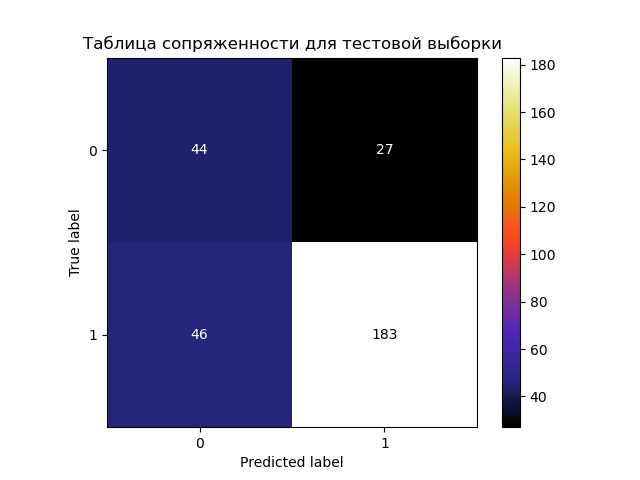

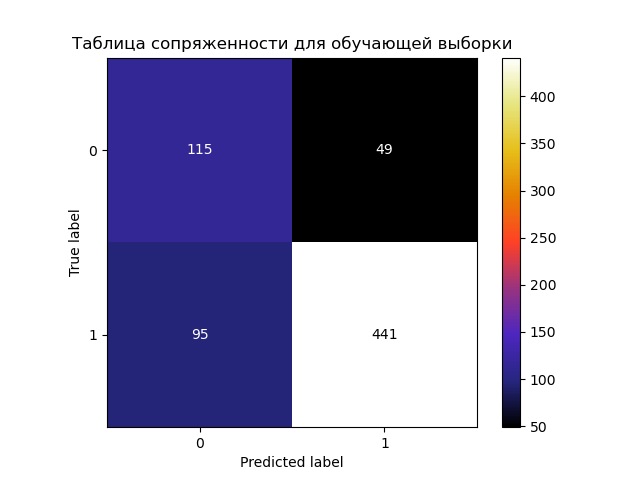

In [143]:
q_1 = df_sample_1.shape[0]/(df_samples.shape[0])
q_2 = df_sample_2.shape[0]/(df_samples.shape[0])
df_n1 = df_sample_1.shape[0]
df_n2 = df_sample_2.shape[0]
p = df_samples.shape[1]


def df_define_class(sample):
    limit = (df_z1_mean + df_z2_mean) / 2 + np.log(q_2/q_1)
    res = []
    for x in sample:
        res.append(1 if np.dot(df_alfa_est, x) >= limit else 0)
    return res

df_mah = ((df_z1_mean - df_z2_mean)**2) / df_sigma_est
df_mah_unbiased = (df_n1 + df_n2 - p - 3) * df_mah / (df_n1 + df_n2 - 2) - p * (1/df_n1 + 1/df_n2)
print(f'Смещенное расстояние Махаланобиса = {df_mah}, \nНесмещенное расстояние Махаланобиса = {df_mah_unbiased}')
df_check = df_define_class(df_test_sample)
F = lambda x: norm.cdf(x)

P_21_est = F((np.log(q_2/q_1) - 0.5*df_mah_unbiased)/np.sqrt(df_mah_unbiased))
P_12_est = F((-np.log(q_2/q_1) - 0.5*df_mah_unbiased)/np.sqrt(df_mah_unbiased))

print(f'\nОценка вероятностей ошибок классификации с использованием несмещенного расстояния Махаланобиса:\nP_21 = {P_21_est}, P_12 = {P_12_est}\nВероятность ошибочной классификации = {P_21_est*q_1 + P_12_est*q_2}')


df_n_samples = df_define_class(df_samples)
df_matrix_2 = confusion_matrix(df_n_samples, np.hstack([np.ones(df_n1), np.zeros(df_n2)]))
df_matrix_2 = np.array(df_matrix_2)

P_21_emp = df_matrix_2[0][1]/(df_matrix_2[0][1]+df_matrix_2[0][0])
P_12_emp = df_matrix_2[1][0]/(df_matrix_2[1][0]+df_matrix_2[1][1])

print(f'\nОценка вероятности ошибок классификации на обучающей выборке \nP_21 = {P_21_emp},P_12 = {P_12_emp}\nВероятность ошибочной классификации = {P_21_emp*q_1 + P_12_emp*q_2}')

df_matrix_1 = confusion_matrix(df_check, np.hstack([np.ones(df_n_1 - df_n1), np.zeros(df_n_2 - df_n2)]))
df_matrix_1 = np.array(df_matrix_1)

P_21_emp = df_matrix_1[0][1]/(df_matrix_1[0][1]+df_matrix_1[0][0])
P_12_emp = df_matrix_1[1][0]/(df_matrix_1[1][0]+df_matrix_1[1][1])

print(f'\nВероятности ошибок классификации на тестовой выборке\nP_21 = {P_21_emp},P_12 = {P_12_emp}\nВероятность ошибочной классификации = {P_21_emp*q_1 + P_12_emp*q_2}')
disp = ConfusionMatrixDisplay(confusion_matrix=df_matrix_1)
disp.plot(cmap='CMRmap')
plt.title("Таблица сопряженности для тестовой выборки")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=df_matrix_2)
disp.plot(cmap='CMRmap')
plt.title("Таблица сопряженности для обучающей выборки")
plt.show()

# Исследования после понижения размерности

In [123]:
def PCA(samp, normalized:bool):
    # Вычисляем среднее значение каждого признака в выборке
    sample_mean = np.mean(samp, axis=0)

    # Вычитаем из каждого признака среднее значение этого признака - центрирование
    sample_centered = samp - sample_mean

    if normalized:
        sample_centered/= np.std(sample_centered, axis=0)
    # Вычисляем ковариационную матрицу
    cov_matrix = np.cov(sample_centered, rowvar=False)

    # Вычисляем собственные значения и собственные векторы ковариационной матрицы
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Вычисляем след матрицы ковариаций
    trace = np.trace(cov_matrix)

    # Вычисляем пороговое значение для собственного числа
    threshold = 1 / p

    # Отбираем главные компоненты, удовлетворяющие условию
    principal_components = []
    for i in range(len(eigenvalues)):
        if normalized:
            if eigenvalues[i] > 1:
                principal_components.append(eigenvectors[:, i])
        else:
            if eigenvalues[i] / trace > threshold:
                principal_components.append(eigenvectors[:, i])

    # Проектируем исходные данные на подпространство, порожденное главными компонентами
    projected_data = np.dot(sample_centered, np.array(principal_components).T)
    return projected_data

In [129]:
# модельные данные из 1-го пункта
sample_1 = multivariate_normal(mean=mu_1, cov=s_cov).rvs(n_1, random_state=123)
sample_2 = multivariate_normal(mean=mu_2, cov=s_cov).rvs(n_2, random_state=123)
p = 3

sample_1 = PCA(sample_1, False)
sample_2 = PCA(sample_2, False)
print(f'Количество оставшихся признаков = {sample_1.shape[1]}')

Количество оставшихся признаков = 1


In [130]:
n_sample_1 = int(0.4 * n_1)
n_sample_2 = int(0.6 * n_2)


# indices_1 = np.random.choice(n_1, n_sample_1, replace=False)
indices_1 = range(n_sample_1)
modified_sample_1 = sample_1[indices_1]

# indices_2 = np.random.choice(n_2, n_sample_2, replace=False)
indices_2 = range(n_sample_2)
modified_sample_2 = sample_2[indices_2]
# Объединяем выборки
modified_sample = np.vstack((modified_sample_1, modified_sample_2))

sample_1 = np.delete(sample_1, indices_1, axis=0)
sample_2 = np.delete(sample_2, indices_2, axis=0)
samples = np.vstack((sample_1, sample_2))

In [131]:
# оценка среднего
mu_1_est = np.mean(sample_1, axis=0)[0]
mu_2_est = np.mean(sample_2, axis=0)[0]

# оценка матрицы ковариаций
s1 = np.var(sample_1, axis=0, ddof=1)
s2 = np.var(sample_2, axis=0, ddof=1)
s_est = 1/(sample_1.shape[0]+sample_2.shape[0]-2)*((sample_1.shape[0]-1)*s1 + (sample_2.shape[0]-1)*s2)


# оценка альфа
alfa_est = s_est * (mu_1_est - mu_2_est)

# z_j, j = 1,2
z_1 = sample_1 * alfa_est
z_1_mean = np.mean(z_1, axis=0)

z_2 = sample_2 * alfa_est
z_2_mean = np.mean(z_2, axis=0)


# оценка дисперсии
sigma = s_est * alfa_est ** 2

Смещенное расстояние Махаланобиса = 0.0012807418149225814, 
Несмещенное расстояние Махаланобиса = 0.0012807418149225814

Оценка вероятностей ошибок классификации с использованием несмещенного расстояния Махаланобиса:
P_21 = 0.08360485274179474, P_12 = 0.9107580560246442
Вероятность ошибочной классификации = 0.4870942201968433

Оценка вероятностей ошибок классификации по обучающей выборке 
P_21 = 0.5129682997118156,P_12 = 0.4883720930232558
Вероятность ошибочной классификации = 0.50097015010764

Вероятности ошибок классификации на тестовой выборке
P_21 = 0.3135593220338983,P_12 = 0.6787072243346007
Вероятность ошибочной классификации = 0.49168024998546045


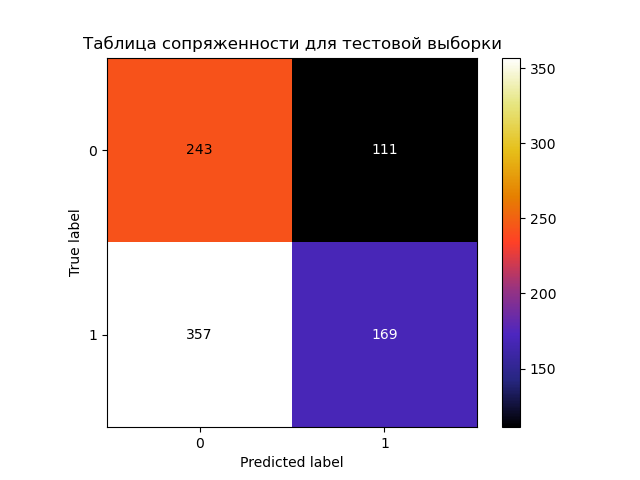

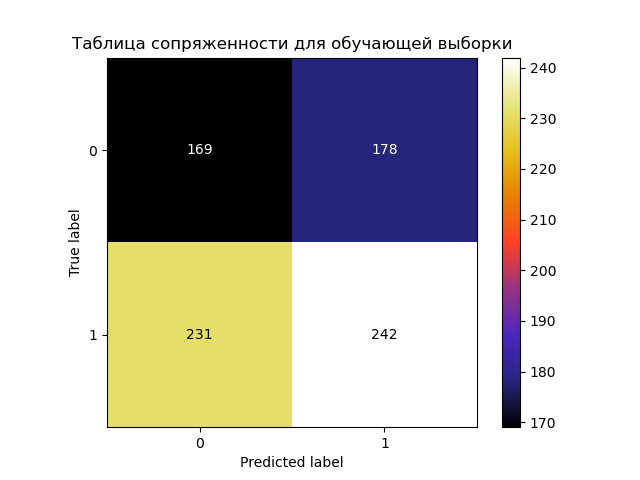

In [132]:
q_1 = sample_1.shape[0]/(samples.shape[0])
q_2 = sample_2.shape[0]/(samples.shape[0])
n1 = sample_1.shape[0]
n2 = sample_2.shape[0]
p = samples.shape[1]


def define_class(sample):
    limit = (z_1_mean + z_2_mean) / 2 + np.log(q_2/q_1)
    res = []
    for x in sample:
        res.append(1 if alfa_est * x >= limit else 0)
    return res

mah = ((z_1_mean - z_2_mean)**2) / sigma
mah_unbiased = (n1 + n2 - p - 3) * mah / (n1 + n2 - 2) - p * (1/n1 + 1/n2)
if mah_unbiased < 0:
    diff = mu_1_est - mu_2_est
    mah = (diff**2 / s_est)[0]
    mah_unbiased = mah * (n1+n2-p-1) / ((n1+n2-2)*p)
F = lambda x: norm.cdf(x)
print(f'Смещенное расстояние Махаланобиса = {mah}, \nНесмещенное расстояние Махаланобиса = {mah_unbiased}')
check = define_class(modified_sample)

P_21_est = F((np.log(q_2/q_1) - 0.5*mah_unbiased)/np.sqrt(mah_unbiased))
P_12_est = F((-np.log(q_2/q_1) - 0.5*mah_unbiased)/np.sqrt(mah_unbiased))

print(f'\nОценка вероятностей ошибок классификации с использованием несмещенного расстояния Махаланобиса:\nP_21 = {P_21_est}, P_12 = {P_12_est}\nВероятность ошибочной классификации = {P_21_est*q_1 + P_12_est*q_2}')
n_samples = define_class(samples)
matrix_2 = confusion_matrix(n_samples, np.hstack([np.ones(n1), np.zeros(n2)]))
matrix_2 = np.array(matrix_2)

P_21_emp = matrix_2[0][1]/(matrix_2[0][1]+matrix_2[0][0])
P_12_emp = matrix_2[1][0]/(matrix_2[1][0]+matrix_2[1][1])

print(f'\nОценка вероятностей ошибок классификации по обучающей выборке \nP_21 = {P_21_emp},P_12 = {P_12_emp}\nВероятность ошибочной классификации = {P_21_emp*q_1 + P_12_emp*q_2}')

matrix_1 = confusion_matrix(check, np.hstack([np.ones(n_1 - n1), np.zeros(n_2 - n2)]))
matrix_1 = np.array(matrix_1)

P_21_emp = matrix_1[0][1]/(matrix_1[0][1]+matrix_1[0][0])
P_12_emp = matrix_1[1][0]/(matrix_1[1][0]+matrix_1[1][1])

print(f'\nВероятности ошибок классификации на тестовой выборке\nP_21 = {P_21_emp},P_12 = {P_12_emp}\nВероятность ошибочной классификации = {P_21_emp*q_1 + P_12_emp*q_2}')
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_1)
disp.plot(cmap='CMRmap')
plt.title("Таблица сопряженности для тестовой выборки")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=matrix_2)
disp.plot(cmap='CMRmap')
plt.title("Таблица сопряженности для обучающей выборки")
plt.show()

Снижение размерности на нормализованных модельных данных

In [137]:
sample_1 = multivariate_normal(mean=mu_1, cov=s_cov).rvs(n_1, random_state=123)
sample_2 = multivariate_normal(mean=mu_2, cov=s_cov).rvs(n_2, random_state=123)
p = 3

sample_1 = PCA(sample_1, True)
sample_2 = PCA(sample_2, True)
print(f'Количество оставшихся признаков = {sample_1.shape[1]}')

Количество оставшихся признаков = 1


In [134]:
n_sample_1 = int(0.4 * n_1)
n_sample_2 = int(0.6 * n_2)


# indices_1 = np.random.choice(n_1, n_sample_1, replace=False)
indices_1 = range(n_sample_1)
modified_sample_1 = sample_1[indices_1]

# indices_2 = np.random.choice(n_2, n_sample_2, replace=False)
indices_2 = range(n_sample_2)
modified_sample_2 = sample_2[indices_2]
# Объединяем выборки
modified_sample = np.vstack((modified_sample_1, modified_sample_2))

sample_1 = np.delete(sample_1, indices_1, axis=0)
sample_2 = np.delete(sample_2, indices_2, axis=0)
samples = np.vstack((sample_1, sample_2))

In [135]:
# оценка среднего
mu_1_est = np.mean(sample_1, axis=0)
mu_2_est = np.mean(sample_2, axis=0)

# оценка матрицы ковариаций
s1 = np.cov(sample_1, rowvar=False, ddof=1)
s2 = np.cov(sample_2, rowvar=False, ddof=1)
s_est = 1/(sample_1.shape[0]+sample_2.shape[0]-2)*((sample_1.shape[0]-1)*s1 + (sample_2.shape[0]-1)*s2)

# оценка альфа
if samples.shape[1] != 1:
    alfa_est = np.dot(np.linalg.inv(s_est),(mu_1_est - mu_2_est))
else:
    alfa_est = s_est * (mu_1_est - mu_2_est)

# z_j, j = 1,2
z_1 = np.dot(sample_1, alfa_est)
z_1_mean = np.mean(z_1, axis=0)

z_2 = np.dot(sample_2, alfa_est)
z_2_mean = np.mean(z_2, axis=0)


# оценка дисперсии
sigma = np.dot(alfa_est, s_est).dot(alfa_est.T)

Смещенное расстояние Махаланобиса = 0.0012517337664313983, 
Несмещенное расстояние Махаланобиса = 0.0012517337664313983

Оценка вероятностей ошибок классификации с использованием несмещенного расстояния Махаланобиса:
P_21 = 0.0812476721079517, P_12 = 0.9132981725850822
Вероятность ошибочной классификации = 0.48712596502362504

Оценка вероятностей ошибок классификации по обучающей выборке 
P_21 = 0.5218579234972678,P_12 = 0.4955947136563877
Вероятность ошибочной классификации = 0.5090466016236678

Вероятности ошибок классификации на тестовой выборке
P_21 = 0.3170731707317073,P_12 = 0.6810176125244618
Вероятность ошибочной классификации = 0.4946070447769534


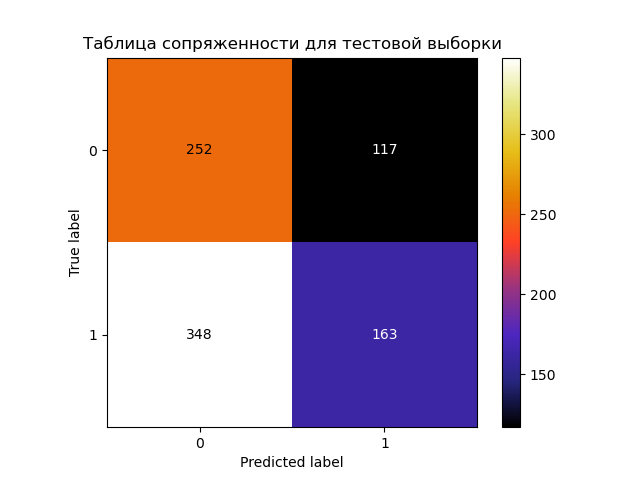

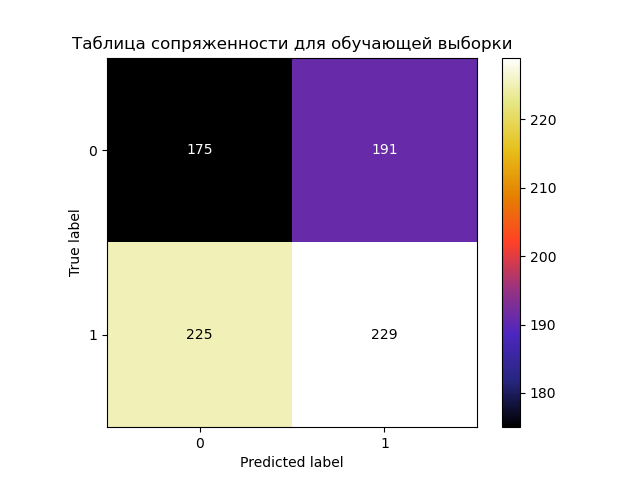

In [136]:
q_1 = sample_1.shape[0]/(samples.shape[0])
q_2 = sample_2.shape[0]/(samples.shape[0])
n1 = sample_1.shape[0]
n2 = sample_2.shape[0]
p = samples.shape[1]


def define_class(sample):
    limit = (z_1_mean + z_2_mean) / 2 + np.log(q_2/q_1)
    res = []
    for x in sample:
        res.append(1 if np.dot(alfa_est, x) >= limit else 0)
    return res

mah = ((z_1_mean - z_2_mean)**2) / sigma
mah_unbiased = (n1 + n2 - p - 3) * mah / (n1 + n2 - 2) - p * (1/n1 + 1/n2)
if mah_unbiased < 0:
    diff = mu_1_est - mu_2_est
    mah = (diff**2 / s_est)[0]
    mah_unbiased = mah * (n1+n2-p-1) / ((n1+n2-2)*p)

print(f'Смещенное расстояние Махаланобиса = {mah}, \nНесмещенное расстояние Махаланобиса = {mah_unbiased}')
check = define_class(modified_sample)

F = lambda x: norm.cdf(x)
# P_21_est = calculate_function((np.log(q_2/q_1) - 0.5*mah_unbiased**2)/mah_unbiased)
# P_12_est = calculate_function((-np.log(q_2/q_1) - 0.5*mah_unbiased**2)/mah_unbiased)
P_21_est = F((np.log(q_2/q_1) - 0.5*mah_unbiased)/np.sqrt(mah_unbiased))
P_12_est = F((-np.log(q_2/q_1) - 0.5*mah_unbiased)/np.sqrt(mah_unbiased))

print(f'\nОценка вероятностей ошибок классификации с использованием несмещенного расстояния Махаланобиса:\nP_21 = {P_21_est}, P_12 = {P_12_est}\nВероятность ошибочной классификации = {P_21_est*q_1 + P_12_est*q_2}')
n_samples = define_class(samples)
matrix_2 = confusion_matrix(n_samples, np.hstack([np.ones(n1), np.zeros(n2)]))
matrix_2 = np.array(matrix_2)

P_21_emp = matrix_2[0][1]/(matrix_2[0][1]+matrix_2[0][0])
P_12_emp = matrix_2[1][0]/(matrix_2[1][0]+matrix_2[1][1])

print(f'\nОценка вероятностей ошибок классификации по обучающей выборке \nP_21 = {P_21_emp},P_12 = {P_12_emp}\nВероятность ошибочной классификации = {P_21_emp*q_1 + P_12_emp*q_2}')

matrix_1 = confusion_matrix(check, np.hstack([np.ones(n_1 - n1), np.zeros(n_2 - n2)]))
matrix_1 = np.array(matrix_1)

P_21_emp = matrix_1[0][1]/(matrix_1[0][1]+matrix_1[0][0])
P_12_emp = matrix_1[1][0]/(matrix_1[1][0]+matrix_1[1][1])

print(f'\nВероятности ошибок классификации на тестовой выборке\nP_21 = {P_21_emp},P_12 = {P_12_emp}\nВероятность ошибочной классификации = {P_21_emp*q_1 + P_12_emp*q_2}')
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_1)
disp.plot(cmap='CMRmap')
plt.title("Таблица сопряженности для тестовой выборки")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=matrix_2)
disp.plot(cmap='CMRmap')
plt.title("Таблица сопряженности для обучающей выборки")
plt.show()

Ненормализованные реальные данные

In [144]:
sample = []
with open("german.data-numeric") as data:
    for string in data:
        string = string.split()
        sample.append(np.array(list(map(lambda elem: float(elem), string))))
sample = np.array(sample)

target = sample[:, -1]
df_sample_pca = sample[:, :-1]
p = df_sample_pca.shape[1]
df_sample_pca = PCA(df_sample_pca, False)
df_1 = df_sample_pca[target == 1]
df_2 = df_sample_pca[target == 2]
p = df_sample_pca.shape[1]

print(f'Количество оставшихся признаков = {p}')

df_n_1 = df_1.shape[0]
df_n_2 = df_2.shape[0]

# выбираем 70% для обучающей выборки и 30% оставляем на тестовую
# df_indices_1 = np.random.choice(df_n_1, int(df_n_1*0.3), replace=False)
df_indices_1 = range(int(df_n_1*0.3))
df_test_sample_1 = df_1[df_indices_1]

# df_indices_2 = np.random.choice(df_n_2, int(df_n_2*0.3), replace=False)
df_indices_2 = range(int(df_n_2*0.3))
df_test_sample_2 = df_2[df_indices_2]

# Объединяем выборки
df_test_sample = np.vstack((df_test_sample_1, df_test_sample_2))

df_sample_1 = np.delete(df_1, df_indices_1, axis=0)
df_sample_2 = np.delete(df_2, df_indices_2, axis=0)
df_samples = np.vstack((df_sample_1, df_sample_2))

Количество оставшихся признаков = 3


Расчет оценок

In [145]:
# оценка среднего
df_mu1 = np.mean(df_sample_1, axis=0)
df_mu2 = np.mean(df_sample_2, axis=0)

# оценка матрицы ковариаций
s1 = np.cov(df_sample_1, rowvar=False, ddof=1)
s2 = np.cov(df_sample_2, rowvar=False, ddof=1)
S = 1/(df_sample_1.shape[0]+df_sample_2.shape[0]-2)*((df_sample_1.shape[0]-1)*s1 + (df_sample_2.shape[0]-1)*s2)

# оценка альфа
df_alfa_est = np.dot(np.linalg.inv(S),(df_mu1 - df_mu2))

# z_j, j = 1,2
df_z1 = np.dot(df_sample_1, df_alfa_est)
df_z1_mean = np.mean(df_z1, axis=0)

df_z2 = np.dot(df_sample_2, df_alfa_est)
df_z2_mean = np.mean(df_z2, axis=0)

# оценка дисперсии
df_sigma_est = np.dot(df_alfa_est, S).dot(df_alfa_est.T)


Оценка вероятностей ошибок классификации с использованием несмещенного расстояния Махаланобиса:
P_21 = 0.019896018524435555, P_12 = 0.9442253737270334
Вероятность ошибочной классификации = 0.2971948250852149

Оценка вероятности ошибок классификации на обучающей выборке 
P_21 = 0.4375,P_12 = 0.2874251497005988
Вероятность ошибочной классификации = 0.3924775449101796

Вероятности ошибок классификации на тестовой выборке
P_21 = 0.47368421052631576,P_12 = 0.2846975088967972
Вероятность ошибочной классификации = 0.4169882000374602


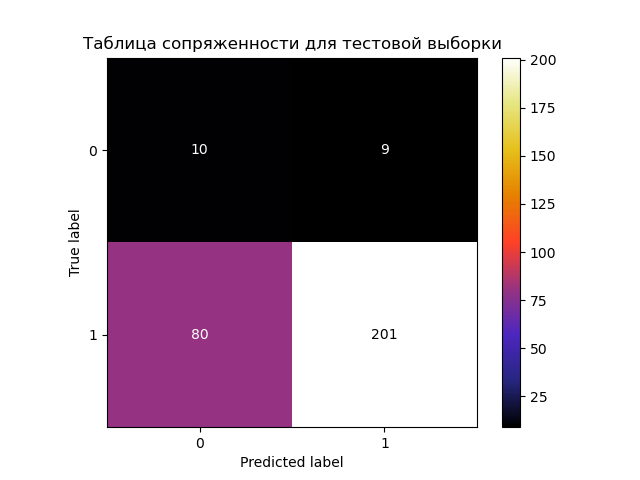

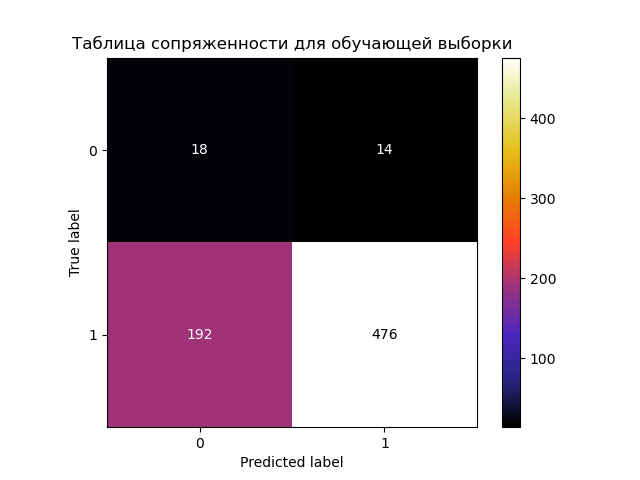

In [146]:
q_1 = df_sample_1.shape[0]/(df_samples.shape[0])
q_2 = df_sample_2.shape[0]/(df_samples.shape[0])
df_n1 = df_sample_1.shape[0]
df_n2 = df_sample_2.shape[0]


def df_define_class(sample):
    limit = (df_z1_mean + df_z2_mean) / 2 + np.log(q_2/q_1)
    res = []
    for x in sample:
        res.append(1 if np.dot(df_alfa_est, x) >= limit else 0)
    return res

df_mah = ((df_z1_mean - df_z2_mean)**2) / df_sigma_est
df_mah_unbiased = (df_n1 + df_n2 - p - 3) * df_mah / (df_n1 + df_n2 - 2) - p * (1/df_n1 + 1/df_n2)

# print(f'Смещенное расстояние Махаланобиса = {df_mah}, \nНеcмещенное расстояние Махаланобиса = {df_mah_unbiased}')
# P_21_est = calculate_function((np.log(q_2/q_1) - 0.5*mah_unbiased**2)/mah_unbiased)
# P_12_est = calculate_function((-np.log(q_2/q_1) - 0.5*mah_unbiased**2)/mah_unbiased)
F = lambda x: norm.cdf(x)

P_21_est = F((np.log(q_2/q_1) - 0.5*df_mah_unbiased)/np.sqrt(df_mah_unbiased))
P_12_est = F((-np.log(q_2/q_1) - 0.5*df_mah_unbiased)/np.sqrt(df_mah_unbiased))

print(f'\nОценка вероятностей ошибок классификации с использованием несмещенного расстояния Махаланобиса:\nP_21 = {P_21_est}, P_12 = {P_12_est}\nВероятность ошибочной классификации = {P_21_est*q_1 + P_12_est*q_2}')

df_check = df_define_class(df_test_sample)

df_n_samples = df_define_class(df_samples)
df_matrix_2 = confusion_matrix(df_n_samples, np.hstack([np.ones(df_n1), np.zeros(df_n2)]))
df_matrix_2 = np.array(df_matrix_2)

P_21_emp = df_matrix_2[0][1]/(df_matrix_2[0][1]+df_matrix_2[0][0])
P_12_emp = df_matrix_2[1][0]/(df_matrix_2[1][0]+df_matrix_2[1][1])

print(f'\nОценка вероятности ошибок классификации на обучающей выборке \nP_21 = {P_21_emp},P_12 = {P_12_emp}\nВероятность ошибочной классификации = {P_21_emp*q_1 + P_12_emp*q_2}')

df_matrix_1 = confusion_matrix(df_check, np.hstack([np.ones(df_n_1 - df_n1), np.zeros(df_n_2 - df_n2)]))
df_matrix_1 = np.array(df_matrix_1)

P_21_emp = df_matrix_1[0][1]/(df_matrix_1[0][1]+df_matrix_1[0][0])
P_12_emp = df_matrix_1[1][0]/(df_matrix_1[1][0]+df_matrix_1[1][1])

print(f'\nВероятности ошибок классификации на тестовой выборке\nP_21 = {P_21_emp},P_12 = {P_12_emp}\nВероятность ошибочной классификации = {P_21_emp*q_1 + P_12_emp*q_2}')
disp = ConfusionMatrixDisplay(confusion_matrix=df_matrix_1)
disp.plot(cmap='CMRmap')
plt.title("Таблица сопряженности для тестовой выборки")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=df_matrix_2)
disp.plot(cmap='CMRmap')
plt.title("Таблица сопряженности для обучающей выборки")
plt.show()

Нормализованные реальные данные

In [147]:
sample = []
with open("german.data-numeric") as data:
    for string in data:
        string = string.split()
        sample.append(np.array(list(map(lambda elem: float(elem), string))))
sample = np.array(sample)

target = sample[:, -1]
df_sample_pca = sample[:, :-1]
p = df_sample_pca.shape[1]
df_sample_pca = PCA(df_sample_pca, True)
df_1 = df_sample_pca[target == 1]
df_2 = df_sample_pca[target == 2]
p = df_sample_pca.shape[1]

print(f'Количество оставшихся признаков = {p}')

df_n_1 = df_1.shape[0]
df_n_2 = df_2.shape[0]

# выбираем 70% для обучающей выборки и 30% оставляем на тестовую
# df_indices_1 = np.random.choice(df_n_1, int(df_n_1*0.3), replace=False)
df_indices_1 = range(int(df_n_1*0.3))
df_test_sample_1 = df_1[df_indices_1]

# df_indices_2 = np.random.choice(df_n_2, int(df_n_2*0.3), replace=False)
df_indices_2 = range(int(df_n_2*0.3))
df_test_sample_2 = df_2[df_indices_2]

# Объединяем выборки
df_test_sample = np.vstack((df_test_sample_1, df_test_sample_2))

df_sample_1 = np.delete(df_1, df_indices_1, axis=0)
df_sample_2 = np.delete(df_2, df_indices_2, axis=0)
df_samples = np.vstack((df_sample_1, df_sample_2))

Количество оставшихся признаков = 10


Расчет оценок

In [148]:
# оценка среднего
df_mu1 = np.mean(df_sample_1, axis=0)
df_mu2 = np.mean(df_sample_2, axis=0)

# оценка матрицы ковариаций
S = np.cov(df_samples, rowvar=False)

# оценка альфа
df_alfa_est = np.dot(np.linalg.inv(S),(df_mu1 - df_mu2))

# z_j, j = 1,2
df_z1 = np.dot(df_sample_1, df_alfa_est)
df_z1_mean = np.mean(df_z1, axis=0)

df_z2 = np.dot(df_sample_2, df_alfa_est)
df_z2_mean = np.mean(df_z2, axis=0)

# оценка дисперсии
df_sigma_est = np.dot(df_alfa_est, S).dot(df_alfa_est.T)


Оценка вероятностей ошибок классификации с использованием несмещенного расстояния Махаланобиса:
P_21 = 0.09073047630604941, P_12 = 0.6185593657569887
Вероятность ошибочной классификации = 0.24907914314133117

Оценка вероятности ошибок классификации на обучающей выборке 
P_21 = 0.2903225806451613,P_12 = 0.21180555555555555
Вероятность ошибочной классификации = 0.26676747311827953

Вероятности ошибок классификации на тестовой выборке
P_21 = 0.3617021276595745,P_12 = 0.23715415019762845
Вероятность ошибочной классификации = 0.3243377344209906


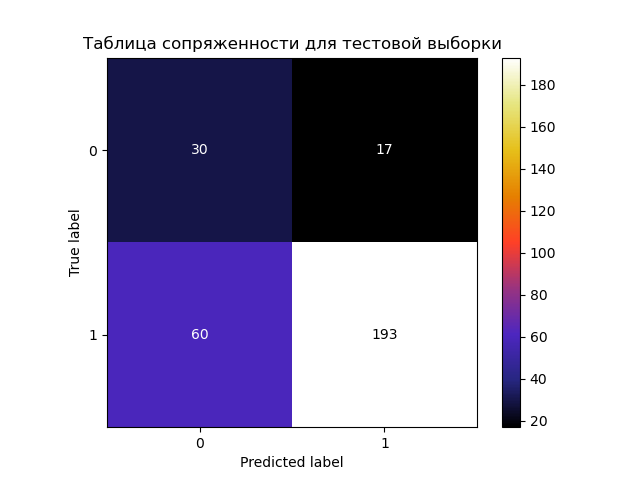

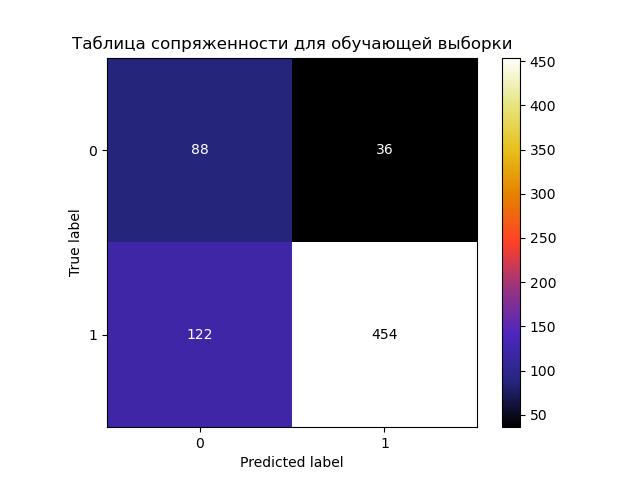

In [149]:
q_1 = df_sample_1.shape[0]/(df_samples.shape[0])
q_2 = df_sample_2.shape[0]/(df_samples.shape[0])
df_n1 = df_sample_1.shape[0]
df_n2 = df_sample_2.shape[0]


def df_define_class(sample):
    limit = (df_z1_mean + df_z2_mean) / 2 + np.log(q_2/q_1)
    res = []
    for x in sample:
        res.append(1 if np.dot(df_alfa_est, x) >= limit else 0)
    return res

df_mah = ((df_z1_mean - df_z2_mean)**2) / df_sigma_est
df_mah_unbiased = (df_n1 + df_n2 - p - 3) * df_mah / (df_n1 + df_n2 - 2) - p * (1/df_n1 + 1/df_n2)
# print(f'Смещенное расстояние Махаланобиса = {df_mah}, \nНеcмещенное расстояние Махаланобиса = {df_mah_unbiased}')

F = lambda x: norm.cdf(x)

P_21_est = F((np.log(q_2/q_1) - 0.5*df_mah_unbiased)/np.sqrt(df_mah_unbiased))
P_12_est = F((-np.log(q_2/q_1) - 0.5*df_mah_unbiased)/np.sqrt(df_mah_unbiased))

print(f'\nОценка вероятностей ошибок классификации с использованием несмещенного расстояния Махаланобиса:\nP_21 = {P_21_est}, P_12 = {P_12_est}\nВероятность ошибочной классификации = {P_21_est*q_1 + P_12_est*q_2}')

df_check = df_define_class(df_test_sample)

# P_21_est = calculate_function_realdata((np.log(q_2/q_1) - 0.5*mah_unbiased**2)/mah_unbiased, df_samples)
# P_12_est = calculate_function_realdata((-np.log(q_2/q_1) - 0.5*mah_unbiased**2)/mah_unbiased, df_samples)
# print(P_21_est,P_12_est)

df_n_samples = df_define_class(df_samples)
df_matrix_2 = confusion_matrix(df_n_samples, np.hstack([np.ones(df_n1), np.zeros(df_n2)]))
df_matrix_2 = np.array(df_matrix_2)

P_21_emp = df_matrix_2[0][1]/(df_matrix_2[0][1]+df_matrix_2[0][0])
P_12_emp = df_matrix_2[1][0]/(df_matrix_2[1][0]+df_matrix_2[1][1])

print(f'\nОценка вероятности ошибок классификации на обучающей выборке \nP_21 = {P_21_emp},P_12 = {P_12_emp}\nВероятность ошибочной классификации = {P_21_emp*q_1 + P_12_emp*q_2}')

df_matrix_1 = confusion_matrix(df_check, np.hstack([np.ones(df_n_1 - df_n1), np.zeros(df_n_2 - df_n2)]))
df_matrix_1 = np.array(df_matrix_1)

P_21_emp = df_matrix_1[0][1]/(df_matrix_1[0][1]+df_matrix_1[0][0])
P_12_emp = df_matrix_1[1][0]/(df_matrix_1[1][0]+df_matrix_1[1][1])

print(f'\nВероятности ошибок классификации на тестовой выборке\nP_21 = {P_21_emp},P_12 = {P_12_emp}\nВероятность ошибочной классификации = {P_21_emp*q_1 + P_12_emp*q_2}')
disp = ConfusionMatrixDisplay(confusion_matrix=df_matrix_1)
disp.plot(cmap='CMRmap')
plt.title("Таблица сопряженности для тестовой выборки")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=df_matrix_2)
disp.plot(cmap='CMRmap')
plt.title("Таблица сопряженности для обучающей выборки")
plt.show()